In [1]:
import pandas as pd 
df = pd.read_json("../datasets/ai_coordination/dataset_294_selection.json")

In [10]:
from transformers import AutoModelForCausalLM
import torch
# The model is loaded in 8-bit on available GPUs using the bitsandbytes library integrated in HF Transformers
# This will make the model much smaller for inference purposes, but attributions are not guaranteed to match those
# of the full-precision model.
model_name = "gpt2" #"meta-llama/Llama-2-7b-chat-hf"
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=False, torch_dtype=torch.float16, device_map="auto")


In [11]:
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
model.transformer.h[layer].mlp

In [ ]:
model.model.layers[0].mlp

LlamaMLP(
  (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
  (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
  (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
  (act_fn): SiLU()
)

In [30]:
import inseq
import copy
# Important: adding a space after the prompt would cause problems since the final space would be tokenized separately
prompt = "The Eiffel Tower is located in the city of"
true_answer = "The Eiffel Tower is located in the city of Paris"
false_answer = "The Eiffel Tower is located in the city of Rome"
out_all = {}
# GPT-2 XL is a Transformer model with 48 layers
layer_num = 12
for layer in range(layer_num):
    attrib_model = inseq.load_model(
        model,
        "attention",#"layer_gradient_x_activation", #"attention"#
        tokenizer=model_name,
        target_layer=model.transformer.h[layer].mlp , #target_layer=model.model.layers[layer].mlp
    )
    
    # Contrastive attribution of true vs false answer
    out = attrib_model.attribute(
        prompt,
        true_answer,
        attributed_fn="contrast_prob_diff",
        contrast_targets=false_answer,
        step_scores=["contrast_prob_diff"],
        show_progress=False,
    )
    # Save aggregated attributions to disk

    ## NEEDS TO BE SAVED FOR LAYERS --> LATER DISK PROBABLY NECCESSARY 
    temp =out.aggregate()
    out_all[layer] = copy.deepcopy(temp)
    #out.save(f"../data/cat_outputs/layer_{layer}.json", overwrite=True)

Internals attribution methods are output agnostic, since they do not rely on specific output targets to compute importance scores. Using a custom attributed function in this context does not influence in any way the method's results.
No target alignments were provided for the contrastive target. Use e.g. 'contrast_targets_alignments=[(0,1), ...] to provide them in model.attribute
Filling missing position with right-aligned 1:1 position alignments.
Internals attribution methods are output agnostic, since they do not rely on specific output targets to compute importance scores. Using a custom attributed function in this context does not influence in any way the method's results.
No target alignments were provided for the contrastive target. Use e.g. 'contrast_targets_alignments=[(0,1), ...] to provide them in model.attribute
Filling missing position with right-aligned 1:1 position alignments.
Internals attribution methods are output agnostic, since they do not rely on specific output tar

In [31]:
import pandas as pd

from inseq import FeatureAttributionOutput

scores = {}
change_of_interest = (11, 'ĠRome → ĠParis') # (12, '▁Rome → ▁Paris')
for layer_idx in range(layer_num):
    curr_out = out_all[layer_idx]#FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
    out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
    scores[layer_idx] = list(out_dict["target_attributions"][change_of_interest].values())[:-1]

prefix_tokens = list(out_dict["target_attributions"][change_of_interest].keys())
attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# Attributed prefix tokens x layers
attributions_df

,0,1,2,3,4,5,6,7,8,9,10,11
"(0, The)",0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385,0.546385
"(1, ĠE)",0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334,0.017334
"(2, iff)",0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009,0.013009
"(3, el)",0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286
"(4, ĠTower)",0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426,0.027426
"(5, Ġis)",0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886,0.032886
"(6, Ġlocated)",0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097,0.030097
"(7, Ġin)",0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680,0.053680
"(8, Ġthe)",0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300,0.057300
"(9, Ġcity)",0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853,0.134853


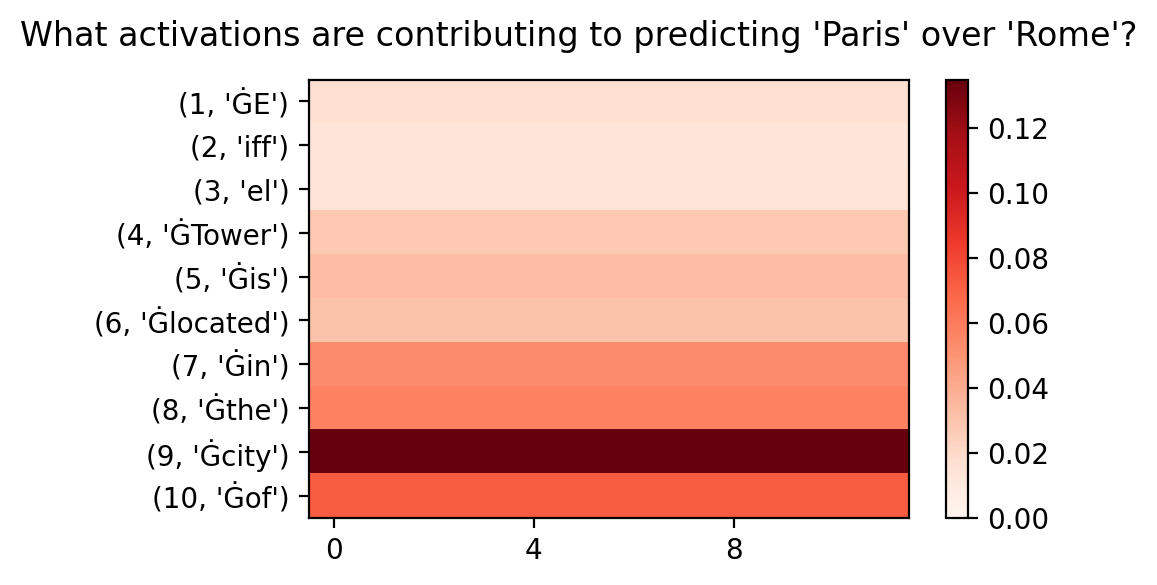

In [32]:
from matplotlib import pyplot as plt

#filename = "../img/cat_example_plot.png"
values = attributions_df.values[1:] #skipping the BOS token
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
plt.subplots_adjust(bottom=0.15, left=0.275)
h = ax.pcolor(
    values, #skipping the first row
    cmap="Reds",
    vmin=0,
    vmax=values.max(),
)
ax.invert_yaxis()
ax.set_yticks([0.5 + i for i in range(len(values))])
ax.set_xticks([0.5 + i for i in range(0, values.shape[1], 4)])
ax.set_xticklabels(list(range(0, layer_num, 4)))
ax.set_yticklabels(attributions_df.index[1:])
cb = plt.colorbar(h)#, ticks=[0, 0.15, 0.3, 0.45, 0.6, 0.75])
fig.suptitle("What activations are contributing to predicting 'Paris' over 'Rome'?")
#plt.savefig(filename)
plt.show()